COMP5329 – Deep Learning
Assignment 1
Team: 
-	vyun8699 - 530454874
-	gzha9095 – [student number]

Note on imports:
- You are NOT allowed to use Deep Learning frameworks (e.g. PyTorch, Tensorflow, Caffe, and KERAS), or any kinds of auto-grad tools (e.g. autograd).
- Scientific computing packages, such as NumPy and SciPy, are acceptable. 

Note on code sources:
- Week 3: activation function, hidden layers, MLP
- Week 4: momentum, AdaGrad, Adam, SGD
- Week 5: dropout, batch normalization

Code penalties:
- well organized, commented, documented [5]
- Badly written code [-20]
- Not including instructions on how to run code (ie. readme.txt) [-30]

In [144]:
#imports
import numpy as np
import matplotlib.pyplot as plt

In [145]:
# Data loading
train_data = np.load('Assignment1-Dataset/train_data.npy')
train_label = np.load('Assignment1-Dataset/train_label.npy')
test_data = np.load('Assignment1-Dataset/test_data.npy')
test_label = np.load('Assignment1-Dataset/test_label.npy')

length of labels: 50000


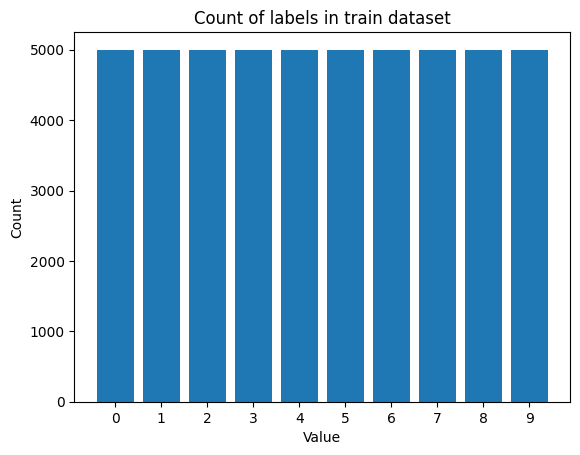

In [146]:
# training dataset is distributed equally

print('length of labels:', len(train_label))

unique_values, counts = np.unique(train_label, return_counts = True)
plt.bar(unique_values, counts)
plt.xticks(unique_values)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Count of labels in train dataset')
plt.show()

In [147]:
# train_data consists of 50'000 list of (128,) float numbers with positive and negative values

train_min = np.min(train_data)
train_max = np.max(train_data)

print('minimum value:', train_min, 'maximum value:', train_max)

minimum value: -23.41520966868848 maximum value: 25.581360537720347


In [148]:
# Pre-processing

# Apply minmax scaling to alter distribution to [0,1]

adj_train_data = (train_data - train_min) / (train_max - train_min)

adj_train_min = np.min(adj_train_data)
adj_train_max = np.max(adj_train_data)

print('new minimum value:', adj_train_min, 'new maximum value:', adj_train_max)

new minimum value: 0.0 new maximum value: 1.0


In [149]:
# apply minmax scaling to test data
# discussion: does this introduce leakage between train test?

adj_test_data = (test_data - train_min) / (train_max - train_min)

In [150]:
# data size scaler
# this is intended to help with initial build (e.g. rather than going through 50k of datapoints, we go through factor * 50k)
# CURRENTLY NOT IN USE

def create_smaller_dataset(train_data, train_label, n):
    smaller_data = []
    smaller_label = []
    
    unique_labels = np.unique(train_label)
    
    for label in unique_labels:
        label_indices = np.where(train_label == label)[0]
        selected_indices = np.random.choice(label_indices, size=int(n*len(label_indices)), replace=False)
        
        smaller_data.extend(train_data[selected_indices])
        smaller_label.extend(train_label[selected_indices])
    
    smaller_data = np.array(smaller_data)
    smaller_label = np.array(smaller_label)
    
    return smaller_data, smaller_label

# Example usage:

n = 0.1  # Factor (e.g., select 10% of data from each class)
smaller_data, smaller_label = create_smaller_dataset(adj_train_data, train_label, n)

print("Shape of smaller_data:", smaller_data.shape)
print("Shape of smaller_label:", smaller_label.shape)


Shape of smaller_data: (5000, 128)
Shape of smaller_label: (5000, 1)


In [151]:
# modules
'''
- More than one hidden layer [5]
- ReLU activation [5]
- Weight decay [5]
- Momentum in SGD [5]
- Dropout [5]
- Softmax and cross entropy loss [5]
- Mini-batch training [5]
- Batch normalization [5]
- Other advanced ops (e.g. GELU, Adam) [5] <<< justify

NOTE: need to show hyperparameter tuning and runtimes
'''

'\n- More than one hidden layer [5]\n- ReLU activation [5]\n- Weight decay [5]\n- Momentum in SGD [5]\n- Dropout [5]\n- Softmax and cross entropy loss [5]\n- Mini-batch training [5]\n- Batch normalization [5]\n- Other advanced ops (e.g. GELU, Adam) [5] <<< justify\n\nNOTE: need to show hyperparameter tuning and runtimes\n'

In [152]:
# create a activation class
# for each time, we can initiale a activation function object with one specific function
# for example: f = Activation("tanh")  means we create a tanh activation function.
# you can define more activation functions by yourself, such as relu!

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    #added in: ReLu

    def __relu(self, x):
        return np.maximum(0,x)

    def __relu_deriv(self, a):
        return np.where(a>1,1,0)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv

In [153]:
# now we define the hidden layer for the mlp
# for example, h1 = HiddenLayer(10, 5, activation="tanh") means we create a layer with 10 dimension input and 5 dimension output, and using tanh activation function.
# notes: make sure the input size of hiddle layer should be matched with the output size of the previous layer!

class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        # if activation == 'logistic':
        #     self.W *= 4

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    
    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes. 
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta, output_layer=False):         
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

In [154]:
class MLP:
    """
    """ 

    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','tanh']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output

    # define the objection/loss function, we use mean sqaure error (MSE) as the loss
    # you can try other loss, such as cross entropy.
    # when you try to change the loss, you should also consider the backward formula for the new loss as well!
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the MSE's delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta

    # backward progress  
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!    
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                
                # backward pass
                loss[it],delta=self.criterion_MSE(y[i],y_hat)
                self.backward(delta)
                y
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i,:])
        return output

/var/folders/p7/l2tdj35j7_g0lpyd2dq42qhh0000gn/T/ipykernel_58769/3650642593.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss[it],delta=self.criterion_MSE(y[i],y_hat)


loss:20.452019


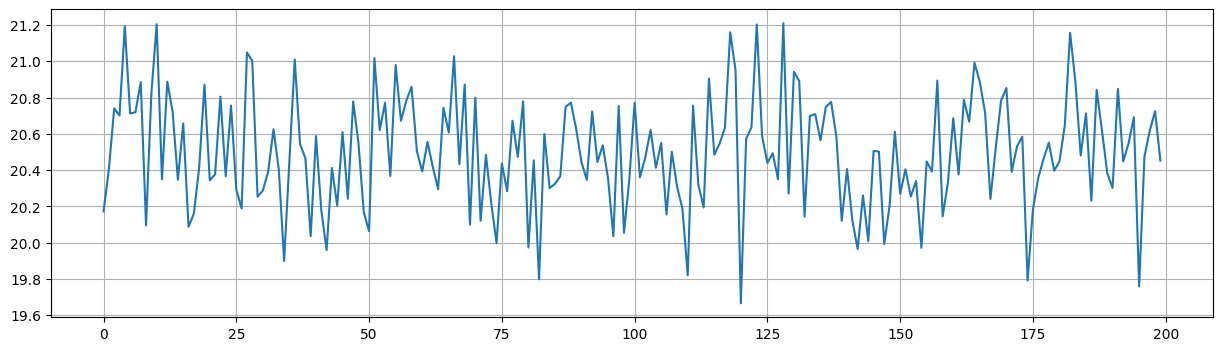

In [155]:
# run with smaller data (5000) over 200 epoch (instead of 500)
nn = MLP([128,64,1], [None,'logistic','tanh'])
input_data = smaller_data
output_data = smaller_label

### Try different learning rate and epochs
MSE = nn.fit(input_data, output_data, learning_rate=0.001, epochs=200)
print('loss:%f'%MSE[-1])

plt.figure(figsize=(15,4))
plt.plot(MSE)
plt.grid()

/var/folders/p7/l2tdj35j7_g0lpyd2dq42qhh0000gn/T/ipykernel_58769/3650642593.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss[it],delta=self.criterion_MSE(y[i],y_hat)


loss:20.471824


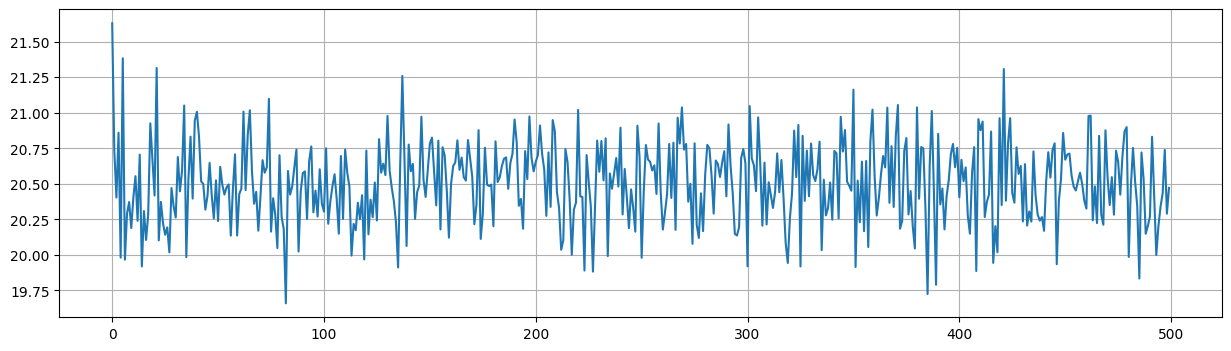

In [156]:
# run with smaller data (5000) over 200 epoch (instead of 500) and learning rate 0.01
nn = MLP([128,64,64,32,1], [None,'relu','relu','relu','tanh'])
input_data = smaller_data
output_data = smaller_label

### Try different learning rate and epochs
MSE = nn.fit(input_data, output_data, learning_rate=0.0001, epochs=500)
print('loss:%f'%MSE[-1])

plt.figure(figsize=(15,4))
plt.plot(MSE)
plt.grid()

/var/folders/p7/l2tdj35j7_g0lpyd2dq42qhh0000gn/T/ipykernel_58769/3650642593.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i] = self.forward(x[i,:])


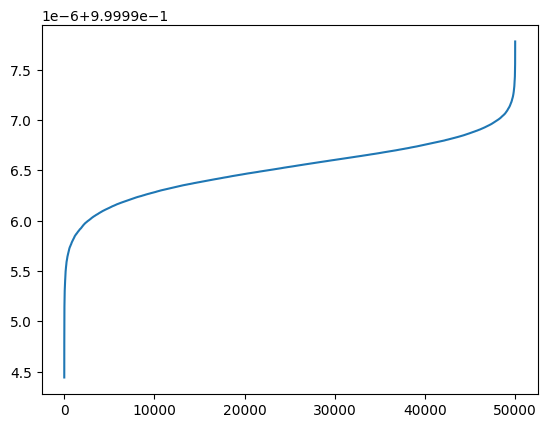

In [157]:
# at this point, this code is still geared for binary classification
# need to implement softmax and cross entropy for this to work

values = nn.predict(adj_train_data)
sorted_values = np.sort(values)
x_values = np.arange(1, len(sorted_values)+1)

plt.plot(x_values, sorted_values)